<a href="https://colab.research.google.com/github/developer-john67/Gaming_app/blob/main/pytorch_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jokamau
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:01<00:00, 372MB/s]


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torchsummary import summary
from torchvision.transforms import transforms
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import os

**READING THE DATA PATHS**

In [3]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

using device: cpu


In [4]:
image_path= []
labels= []

for i in os.listdir("/content/animal-faces/afhq"):# Looping through the first directory which has the train and val images
  print(i)
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"): # Looping through the first directory which has the labels folders
    print(label)
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):# Looping through all the images of this label
      print(image)
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")
      labels.append(label)
df= pd.DataFrame(zip(image_path, labels), columns= ["image_paths", "labels"])
df.head()

val
dog
pixabay_dog_001687.jpg
pixabay_dog_000039.jpg
pixabay_dog_001449.jpg
pixabay_dog_001231.jpg
pixabay_dog_000504.jpg
pixabay_dog_000395.jpg
pixabay_dog_002366.jpg
pixabay_dog_002030.jpg
pixabay_dog_000507.jpg
pixabay_dog_001978.jpg
pixabay_dog_002035.jpg
pixabay_dog_001835.jpg
pixabay_dog_001806.jpg
pixabay_dog_003465.jpg
pixabay_dog_001860.jpg
pixabay_dog_000393.jpg
flickr_dog_001042.jpg
pixabay_dog_003710.jpg
pixabay_dog_001901.jpg
flickr_dog_000545.jpg
pixabay_dog_000848.jpg
pixabay_dog_001854.jpg
pixabay_dog_003261.jpg
pixabay_dog_002144.jpg
pixabay_dog_001356.jpg
flickr_dog_000687.jpg
pixabay_dog_002402.jpg
flickr_dog_001038.jpg
pixabay_dog_000227.jpg
pixabay_dog_000550.jpg
pixabay_dog_003105.jpg
flickr_dog_000454.jpg
pixabay_dog_001341.jpg
pixabay_dog_002909.jpg
pixabay_dog_003726.jpg
pixabay_dog_000647.jpg
flickr_dog_000258.jpg
pixabay_dog_002556.jpg
flickr_dog_001067.jpg
pixabay_dog_001962.jpg
pixabay_dog_000327.jpg
pixabay_dog_001609.jpg
pixabay_dog_003449.jpg
pixabay_do

,image_paths,labels
0,/content/animal-faces/afhq/val/dog/pixabay_dog...,dog
1,/content/animal-faces/afhq/val/dog/pixabay_dog...,dog
2,/content/animal-faces/afhq/val/dog/pixabay_dog...,dog
3,/content/animal-faces/afhq/val/dog/pixabay_dog...,dog
4,/content/animal-faces/afhq/val/dog/pixabay_dog...,dog


**DATA SPLITTING**

In [13]:
train= df.sample(frac= 0.7, random_state= 7)
test= df.drop(train.index)

val= test.sample(frac= 0.5, random_state= 7)
test= test.drop(val.index)

**PREPROCESSING DATA**


In [14]:
lbl= LabelEncoder()
lbl.fit(df["labels"])
transform = transforms.Compose([
    transforms.Resize((128, 128)), # One size for all images
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.ConvertImageDtype(torch.float) # The values are in floating point numbers
    ])

**CUSTOM DATASET CLASS**

In [25]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
          image = self.transform(image).to(device)

        return image, label

**CREATING DATASET OBJECTS**

In [16]:
train_dataset= ImageDataset(dataframe= train, transform= transform)
val_dataset= ImageDataset(dataframe= val, transform= transform)
test_dataset= ImageDataset(dataframe= test, transform= transform)

**VISUALIZING IMAGES**

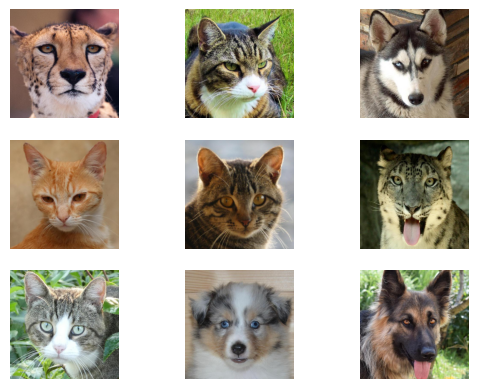

In [17]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
    for col in range(n_cols):
      image = Image.open(df.sample(n = 1)['image_paths'].iloc[0]).convert("RGB") #
      axarr[row, col].imshow(image)
      axarr[row, col].axis('off')

plt.show()

In [18]:
lr= 1e-4
batch_size= 16
epochs= 10

**DATALOADERS**

In [19]:
train_loader= DataLoader(train_dataset, batch_size= batch_size, shuffle= True)
test_loader= DataLoader(test_dataset, batch_size= batch_size, shuffle= False)
val_loader= DataLoader(val_dataset, batch_size= batch_size, shuffle= False)

In [20]:
class ImageModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1= nn.Conv2d(3, 32, kernel_size= 3, padding= 1)
    self.conv2= nn.Conv2d(32, 64, kernel_size= 3, padding = 1)
    self.conv3= nn.Conv2d(64, 128, kernel_size= 3, padding= 1)
    self.pooling= nn.MaxPool2d(2, 2)
    self.relu= nn.ReLU()
    self.flatten= nn.Flatten()

    self.fc1= nn.Linear((128*16*16), 128)
    self.fc2= nn.Linear(128, len(df['labels'].unique()))

  def forward(self, x):
    x= self.conv1(x)
    x= self.pooling(x)
    x= self.relu(x)
    x= self.conv2(x)
    x= self.pooling(x)
    x= self.relu(x)
    x= self.conv3(x)
    x= self.pooling(x)
    x= self.relu(x)
    x= self.flatten(x)
    x=self.fc1(x)
    x=self.fc2(x)
    return x

In [21]:
model= ImageModel().to(device)

In [22]:
summary(model, input_size= (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [23]:
optimizer= optim.Adam(model.parameters(), lr= lr)
criterion= nn.CrossEntropyLoss()

In [26]:
model.to(device)

for epoch in range(epochs):
    model.train()

    total_acc_train = 0
    total_loss_train = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss_train += loss.item()
        total_acc_train += (outputs.argmax(1) == labels).sum()

    model.eval()
    total_loss_val = 0
    total_acc_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss_val += loss.item()
            total_acc_val += (outputs.argmax(1) == labels).sum()

    total_acc_train = total_acc_train.item()
    total_acc_val = total_acc_val.item()


KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
  model.eval()
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")

**VISUALIZING THE TRAINING PROGRESS**

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

In [ ]:
def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return label_encoder.inverse_transform([output])

## Visualize the image
image = Image.open("/content/cute-photos-of-cats-looking-at-camera-1593184780.jpg")
plt.imshow(image)
plt.show()


## Predict
print()
print("Prediction: \n")
predict_image("/content/cute-photos-of-cats-looking-at-camera-1593184780.jpg")

# Task
Refine and optimize the image classification model by improving data path reading efficiency, correcting data splitting logic to ensure distinct sets, fixing the custom dataset class implementation, and refining the training and validation loop logic for the dataset located at "/content/animal-faces/afhq".

## Optimize Data Path Reading

### Subtask:
Improve the efficiency of reading image paths by using `os.walk` or `glob` and removing unnecessary print statements. This addresses potential performance issues in cell `u3Yqj9XGvCQ3`.


**Reasoning**:
To improve efficiency and remove unnecessary print statements, I will replace the nested `os.listdir` loops with `glob.glob` to gather image paths and extract labels from them, then construct the DataFrame.



# Task
To optimize data path reading, I'll replace the nested `os.listdir` loops with `glob.glob` to efficiently gather all image file paths. Then, I'll extract the labels directly from these paths and construct the DataFrame, removing the unnecessary print statements.

```python
import glob

image_paths = glob.glob("/content/animal-faces/afhq/*/*/*.jpg")
labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]

df = pd.DataFrame(zip(image_paths, labels), columns=["image_paths", "labels"])
df.head()
```

## Optimize Data Path Reading

### Subtask:
Improve the efficiency of reading image paths by using `os.walk` or `glob` and removing unnecessary print statements, which can be slow for large datasets. This addresses potential performance issues in cell `u3Yqj9XGvCQ3`.


**Reasoning**:
To improve efficiency and remove unnecessary print statements, I will replace the nested `os.listdir` loops with `glob.glob` to gather image paths and extract labels from them, then construct the DataFrame.



In [ ]:
import glob

image_paths = glob.glob("/content/animal-faces/afhq/**/*.jpg", recursive=True)
labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]

df = pd.DataFrame(zip(image_paths, labels), columns=["image_paths", "labels"])
df.head()

## Correct Data Splitting Logic

### Subtask:
Refine the data splitting logic in cell `yxMNOR5f1N_7` to ensure clear separation of training, validation, and test sets. The current implementation might lead to an overlap between validation and test sets, causing data leakage during evaluation. Propose using `train_test_split` or explicit fractional sampling to create distinct sets.


**Reasoning**:
To refine the data splitting logic and ensure clear separation of training, validation, and test sets, I will use `train_test_split` from `sklearn.model_selection`. I'll first split the data into training and a temporary set, and then split the temporary set into validation and test sets.



In [ ]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, train_size=0.7, random_state=7)
val_df, test_df = train_test_split(temp_df, train_size=0.5, random_state=7)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")
print(f"Total dataset size: {len(df)}")

train = train_df
val = val_df
test = test_df